>> 1. 데이터 증강 (Data Augmentation)


학습 데이터로 만든 모델은 학습데이터에 최적화되어 학습이 됩니다. 

앞의 강의에서 마스크 모델을 실제 영상에 적용한다면 얼굴의 크기나 각도, 밝기 등에 따라 잘 인식 못하는 것이 생길 것입니다. 

따라서 학습데이터셋에서 높은 정확도가 나왔더라도 다양한 환경에서 인식이 가능하도록 모델의 안정성을 높일 필요가 있습니다. 

데이터 증강을 통해서 동일 데이터셋을 변형하여 학습데이터 양을 늘려서 모델이 실제 환경에서 더 잘 인식할 수 있도록 할 수 있습니다. 

https://www.the-analytics.club/media/images/data-augment-example.original.jpg?ezimgfmt=rs:573x322/rscb1/ng:webp/ngcb1

마스크 데이터 셋을 불러서 데이터 증강을 해봅시다

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

data_dir = '/content/drive/MyDrive/Tensorflow AI/New Masks Dataset'

img_height = 150
img_width = 150

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/Train',    
  image_size=(img_height, img_width))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/Validation',    
  image_size=(img_height, img_width))

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/Test',    
  image_size=(img_height, img_width))

Found 600 files belonging to 2 classes.
Found 306 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


Data Augmentation 모델을 만들어 줍니다

Flip과 회전을 적용해보겠습니다

참고링크
https://www.tensorflow.org/tutorials/images/data_augmentation

In [3]:
from tensorflow.keras import models, layers

augmentation = models.Sequential([
                                  layers.RandomFlip("horizontal"), 
                                  layers.RandomRotation(0.2),
])

불러온 이미지에 augmentation을 적용해보겠습니다. 

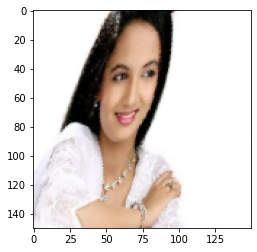

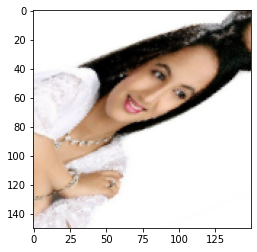

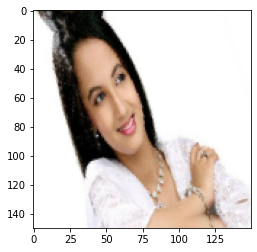

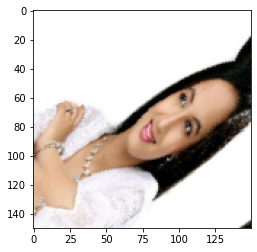

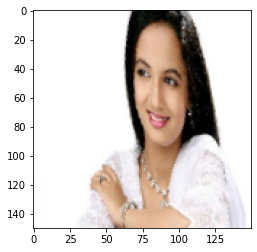

In [4]:
import matplotlib.pyplot as plt

aug_imgs = []
for images, _ in train_ds.take(1):  # 1개의 batch를 불러옴, batch_size를 입력하지 않으면 기본값인 32개가 넘어옴
  for i in range(5):
    aug = augmentation(images[0])  # 첫번째 이미지에 augmentation 적용해봅니다
    plt.figure()
    plt.imshow(aug.numpy().astype('int'))
    aug_imgs.append(aug)


>> 2. 데이터 증강을 통한 모델 학습

Transfer Learning에서 활용한 VGG 모델을 불러오고 ,
Data Augmentation을 추가합니다. 

In [5]:
from tensorflow.keras.applications import VGG16
vgg_model = VGG16(weights = 'imagenet',include_top=False, input_shape=(150,150,3))
vgg_model.trainable = False

In [6]:
from tensorflow.keras import Sequential, Model, layers
aug_model = Sequential()

# augmentation을 추가합니다. 
aug_model.add(augmentation)

aug_model.add(vgg_model)
aug_model.add(layers.Flatten())
aug_model.add(layers.Dense(256,activation='relu'))
aug_model.add(layers.Dropout(0.5))
aug_model.add(layers.Dense(2,activation='softmax'))


데이터 증강을 통한 학습 시에는 데이터 변형이된 이미지들이 학습되므로 원래의 학습데이터보다 많은 데이터를 학습하는 것과 유사합니다. 따라서 Epoch를 좀 더 길게해서 충분히 학습 해줍니다

In [7]:
aug_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = aug_model.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
19/19 [==============================] - 13s 423ms/step - loss: 7.1057 - acc: 0.8183 - val_loss: 1.3906 - val_acc: 0.9739
Epoch 2/30
19/19 [==============================] - 6s 275ms/step - loss: 3.1928 - acc: 0.9200 - val_loss: 0.9299 - val_acc: 0.9739
Epoch 3/30
19/19 [==============================] - 6s 286ms/step - loss: 1.4748 - acc: 0.9500 - val_loss: 1.0199 - val_acc: 0.9771
Epoch 4/30
19/19 [==============================] - 6s 283ms/step - loss: 1.0747 - acc: 0.9483 - val_loss: 1.0122 - val_acc: 0.9771
Epoch 5/30
19/19 [==============================] - 6s 283ms/step - loss: 0.9456 - acc: 0.9500 - val_loss: 0.9144 - val_acc: 0.9771
Epoch 6/30
19/19 [==============================] - 6s 287ms/step - loss: 0.7904 - acc: 0.9533 - val_loss: 0.5300 - val_acc: 0.9739
Epoch 7/30
19/19 [==============================] - 7s 322ms/step - loss: 0.2718 - acc: 0.9567 - val_loss: 0.3260 - val_acc: 0.9804
Epoch 8/30
19/19 [==============================] - 6s 286ms/step - loss: 0

테스트셋 정확도는 이전의 Transfer Learning 적용 모델과 비슷하게 높게 나옵니다. 

In [19]:
# 테스트셋 정확도 평가

test_loss , test_acc = aug_model.evaluate(test_ds)
print('test acc :{} test loss:{}'.format(test_acc,test_loss))

4/4 [==============================] - 1s 76ms/step - loss: 0.2011 - acc: 0.9900
test acc :0.9900000095367432 test loss:0.20111310482025146


In [20]:
# 모델 저장하기
aug_model.save(data_dir+'mask_aug.h5')

augmentation된 이미지로 두개의 모델의 예측을 비교해봅시다. 

In [21]:
import numpy as np
aug_imgs_np = np.array(aug_imgs)

In [22]:
aug_imgs_np.shape

(5, 150, 150, 3)

In [23]:
aug_pred = aug_model.predict(aug_imgs_np)

In [24]:
aug_pred_y = aug_pred.argmax(axis=1)

데이터 증강을 통해 학습한 모델은 rotation이 되어 있어도 정확히 인식하고 있습니다

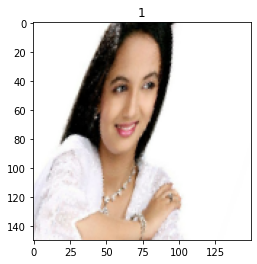

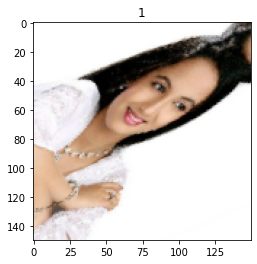

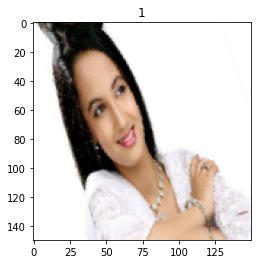

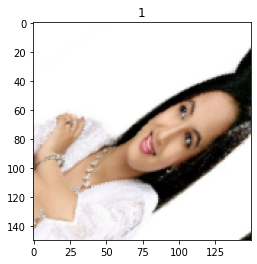

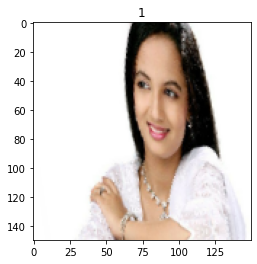

In [25]:

for i in range(5):
  plt.figure()
  plt.imshow(aug_imgs_np[i].astype('int'))
  plt.title(aug_pred_y[i])
  


이전의 전이 학습 모델을 불러와서 결과를 비교해봅시다. 

In [26]:
transfer_model = tf.keras.models.load_model(data_dir + 'mask_tl.h5')

In [27]:
tl_pred = transfer_model.predict(aug_imgs_np)

In [28]:
tl_pred_y = tl_pred.argmax(axis=1)

Transfer Learning 만 적용한 모델은 이미지의 회전 등이 있을 때 제대로 판별하지 못하고 있습니다. 

따라서 학습데이터와 달리 실제 환경에서 촬영각도나 조도가 달라지는 경우에는 
데이터 증강을 통해 학습하는 것이 모델의 정확성을 유지하는데 큰 도움이 됩니다. 

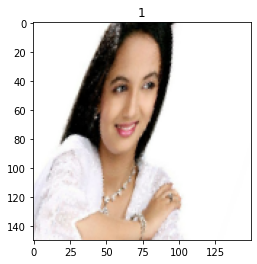

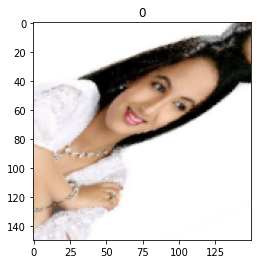

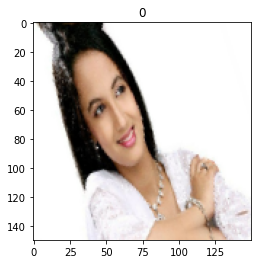

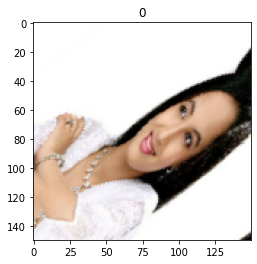

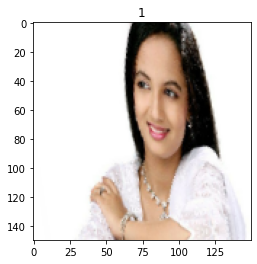

In [30]:

for i in range(5):
  plt.figure()
  plt.imshow(aug_imgs_np[i].astype('int'))
  plt.title(tl_pred_y[i])
  